<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/LSTM_AE/LSTM_AE_Gilt10y.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 147 (delta 71), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (147/147), 120.19 KiB | 815.00 KiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Thu Jul 15 15:00:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Gilt10y'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'LSTM_AE'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8MB 5.2MB/s 
     |████████████████████████████████| 102kB 14.4MB/s 
     |████████████████████████████████| 174kB 49.9MB/s 
     |████████████████████████████████| 143kB 57.4MB/s 
     |████████████████████████████████| 71kB 10.9MB/s 


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'dropout': {
            'values': [0.1, 0.2, 0.3]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop']
        },
        'activation': {
            'values': ['tanh', 'relu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'dropout': 0.2,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(LSTM(units=128, return_sequences=True, input_shape=(window_len, 1), activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 2
    model.add(LSTM(units=64, return_sequences=False, activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 3
    model.add(RepeatVector(window_len))
    # layer 4
    model.add(LSTM(units=64, return_sequences=True, activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 5
    model.add(LSTM(units=128, return_sequences=False, activation=config.activation))
    model.add(Dropout(0.1))
    # layer 6
    model.add((Dense(1)))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: tguovqul
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_LSTM_AE/sweeps/tguovqul


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: j1yzbvuh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/200
16/16 [==============================] - 24s 130ms/step - loss: 0.1467 - mean_squared_error: 0.1467 - mean_absolute_error: 0.3011 - val_loss: 0.0574 - val_mean_squared_error: 0.0574 - val_mean_absolute_error: 0.2044
Epoch 2/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0223 - mean_squared_error: 0.0223 - mean_absolute_error: 0.1128 - val_loss: 0.0342 - val_mean_squared_error: 0.0342 - val_mean_absolute_error: 0.1554
Epoch 3/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0148 - mean_squared_error: 0.0148 - mean_absolute_error: 0.0981 - val_loss: 0.0432 - val_mean_squared_error: 0.0432 - val_mean_absolute_error: 0.1722
Epoch 4/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0176 - mean_squared_error: 0.0176 - mean_absolute_error: 0.1044 - val_loss: 0.0344 - val_mean_squared_error: 0.0344 - val_mean_absolute_error: 0.1435
Epoch 5/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0146 - mean_square

epoch,93
loss,0.00149
mean_squared_error,0.00149
mean_absolute_error,0.02961
val_loss,0.0055
val_mean_squared_error,0.0055
val_mean_absolute_error,0.05634
_runtime,56
_timestamp,1626361340
_step,93
best_val_loss,0.00533


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▂▂▂▂▂▁▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▃▄▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▃▄▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▄▃▃▃▃▂▃▃▂▂▂▂▂▂▁▂▂▂▁▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: vyy2zm8d with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 15s 317ms/step - loss: 0.2004 - mean_squared_error: 0.2004 - mean_absolute_error: 0.3875 - val_loss: 0.0671 - val_mean_squared_error: 0.0671 - val_mean_absolute_error: 0.2250
Epoch 2/200
16/16 [==============================] - 3s 201ms/step - loss: 0.0301 - mean_squared_error: 0.0301 - mean_absolute_error: 0.1462 - val_loss: 0.0265 - val_mean_squared_error: 0.0265 - val_mean_absolute_error: 0.1374
Epoch 3/200
16/16 [==============================] - 3s 188ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0831 - val_loss: 0.0214 - val_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.1213
Epoch 4/200
16/16 [==============================] - 3s 187ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0569 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.1130
Epoch 5/200
16/16 [==============================] - 3s 202ms/step - loss: 0.0040 - mean_sq

epoch,125
loss,0.00122
mean_squared_error,0.00122
mean_absolute_error,0.02723
val_loss,0.01022
val_mean_squared_error,0.01022
val_mean_absolute_error,0.07703
_runtime,397
_timestamp,1626361749
_step,125
best_val_loss,0.00874


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ih52xwd0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 8s 239ms/step - loss: 0.3462 - mean_squared_error: 0.3462 - mean_absolute_error: 0.4325 - val_loss: 0.0298 - val_mean_squared_error: 0.0298 - val_mean_absolute_error: 0.1339
Epoch 2/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0786 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - val_mean_absolute_error: 0.1226
Epoch 3/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0727 - val_loss: 0.0283 - val_mean_squared_error: 0.0283 - val_mean_absolute_error: 0.1279
Epoch 4/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0805 - val_loss: 0.0247 - val_mean_squared_error: 0.0247 - val_mean_absolute_error: 0.1202
Epoch 5/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0117 - mean_squared_error: 0.

epoch,19
loss,0.00783
mean_squared_error,0.00783
mean_absolute_error,0.06956
val_loss,0.02678
val_mean_squared_error,0.02678
val_mean_absolute_error,0.12772
_runtime,16
_timestamp,1626361836
_step,19
best_val_loss,0.01916


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▂▁▂▂▂▁▁▂▁▁▂▁▁▁▁▁
val_loss,▆▃▅▃▂██▄▁▁▃▄▆▇▄▇▃▄▁▄
val_mean_squared_error,▆▃▅▃▂██▄▁▁▃▄▆▇▄▇▃▄▁▄
val_mean_absolute_error,▆▃▄▃▂██▄▁▁▄▅▇█▅▇▄▄▁▄
_runtime,▁▁▁▃▃▃▃▃▃▆▆▆▆▆▆▆████
_timestamp,▁▁▁▃▃▃▃▃▃▆▆▆▆▆▆▆████
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: 2j5dsd2i with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 11s 323ms/step - loss: 0.2137 - mean_squared_error: 0.2137 - mean_absolute_error: 0.3969 - val_loss: 0.0266 - val_mean_squared_error: 0.0266 - val_mean_absolute_error: 0.1346
Epoch 2/100
16/16 [==============================] - 3s 186ms/step - loss: 0.0141 - mean_squared_error: 0.0141 - mean_absolute_error: 0.0924 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - val_mean_absolute_error: 0.1211
Epoch 3/100
16/16 [==============================] - 3s 182ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0741 - val_loss: 0.0277 - val_mean_squared_error: 0.0277 - val_mean_absolute_error: 0.1260
Epoch 4/100
16/16 [==============================] - 3s 186ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0678 - val_loss: 0.0328 - val_mean_squared_error: 0.0328 - val_mean_absolute_error: 0.1388
Epoch 5/100
16/16 [==============================] - 3s 189ms/step - loss: 0.0081 - mean_sq

epoch,55
loss,0.00205
mean_squared_error,0.00205
mean_absolute_error,0.03466
val_loss,0.01896
val_mean_squared_error,0.01896
val_mean_absolute_error,0.10772
_runtime,183
_timestamp,1626362032
_step,55
best_val_loss,0.01615


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▅█▅▅▄▆▄▄█▃▃▃▆▃▂▇▃▄▃▂▂▃▃▄▃▂▄▂▂▃▂▁▃▄▃▂▂▂▃
val_mean_squared_error,▇▅█▅▅▄▆▄▄█▃▃▃▆▃▂▇▃▄▃▂▂▃▃▄▃▂▄▂▂▃▂▁▃▄▃▂▂▂▃
val_mean_absolute_error,█▅▆▅▅▃▅▄▄█▃▃▄▆▃▂▇▃▄▃▃▂▃▃▄▃▂▄▂▂▃▁▁▃▄▃▁▁▂▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: zb5uhak7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 11s 309ms/step - loss: 0.2216 - mean_squared_error: 0.2216 - mean_absolute_error: 0.4142 - val_loss: 0.0337 - val_mean_squared_error: 0.0337 - val_mean_absolute_error: 0.1514
Epoch 2/200
16/16 [==============================] - 3s 214ms/step - loss: 0.0317 - mean_squared_error: 0.0317 - mean_absolute_error: 0.1471 - val_loss: 0.0331 - val_mean_squared_error: 0.0331 - val_mean_absolute_error: 0.1490
Epoch 3/200
16/16 [==============================] - 3s 198ms/step - loss: 0.0179 - mean_squared_error: 0.0179 - mean_absolute_error: 0.1057 - val_loss: 0.0247 - val_mean_squared_error: 0.0247 - val_mean_absolute_error: 0.1278
Epoch 4/200
16/16 [==============================] - 3s 204ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0701 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - val_mean_absolute_error: 0.1194
Epoch 5/200
16/16 [==============================] - 3s 199ms/step - loss: 0.0060 - mean_sq

epoch,66
loss,0.00173
mean_squared_error,0.00173
mean_absolute_error,0.0327
val_loss,0.01628
val_mean_squared_error,0.01628
val_mean_absolute_error,0.09962
_runtime,219
_timestamp,1626362263
_step,66
best_val_loss,0.01531


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_mean_squared_error,██▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_mean_absolute_error,██▄▄▄▄▃▄▃▃▃▃▃▃▃▃▂▂▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: e3a27kz4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 9s 413ms/step - loss: 0.2397 - mean_squared_error: 0.2397 - mean_absolute_error: 0.4392 - val_loss: 0.1556 - val_mean_squared_error: 0.1556 - val_mean_absolute_error: 0.3327
Epoch 2/200
8/8 [==============================] - 2s 191ms/step - loss: 0.1258 - mean_squared_error: 0.1258 - mean_absolute_error: 0.2970 - val_loss: 0.0401 - val_mean_squared_error: 0.0401 - val_mean_absolute_error: 0.1723
Epoch 3/200
8/8 [==============================] - 2s 191ms/step - loss: 0.0357 - mean_squared_error: 0.0357 - mean_absolute_error: 0.1566 - val_loss: 0.0382 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1567
Epoch 4/200
8/8 [==============================] - 1s 176ms/step - loss: 0.0262 - mean_squared_error: 0.0262 - mean_absolute_error: 0.1213 - val_loss: 0.0287 - val_mean_squared_error: 0.0287 - val_mean_absolute_error: 0.1394
Epoch 5/200
8/8 [==============================] - 1s 181ms/step - loss: 0.0143 - mean_squared_error

epoch,44
loss,0.00238
mean_squared_error,0.00238
mean_absolute_error,0.03813
val_loss,0.02008
val_mean_squared_error,0.02008
val_mean_absolute_error,0.1114
_runtime,83
_timestamp,1626362359
_step,44
best_val_loss,0.01886


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: pxa31fas with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 14s 234ms/step - loss: 2.9316 - mean_squared_error: 2.9316 - mean_absolute_error: 0.4615 - val_loss: 0.0242 - val_mean_squared_error: 0.0242 - val_mean_absolute_error: 0.1258
Epoch 2/100
32/32 [==============================] - 6s 184ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0570 - val_loss: 0.0235 - val_mean_squared_error: 0.0235 - val_mean_absolute_error: 0.1218
Epoch 3/100
32/32 [==============================] - 6s 182ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0626 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - val_mean_absolute_error: 0.1237
Epoch 4/100
32/32 [==============================] - 6s 183ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0591 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - val_mean_absolute_error: 0.1207
Epoch 5/100
32/32 [==============================] - 6s 185ms/step - loss: 0.0089 - mean_sq

epoch,74
loss,0.00169
mean_squared_error,0.00169
mean_absolute_error,0.03237
val_loss,0.01082
val_mean_squared_error,0.01082
val_mean_absolute_error,0.08175
_runtime,469
_timestamp,1626362841
_step,74
best_val_loss,0.00921


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▆▆█▆▅▆▅▇▄▅▇▅▄▄▃▃▂▂▄▂▂▂▂▃▂▂▂▁▁▂▂▂▁▁▁▁▂▁▂
val_mean_squared_error,▆▆▆█▆▅▆▅▇▄▅▇▅▄▄▃▃▂▂▄▂▂▂▂▃▂▂▂▁▁▂▂▂▁▁▁▁▂▁▂
val_mean_absolute_error,▇▇▇█▆▅▆▆█▄▅▇▅▅▅▃▃▃▃▅▃▃▂▂▃▂▂▂▂▁▃▂▂▁▁▁▂▂▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: bk3owbpv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 8s 250ms/step - loss: 2.1442 - mean_squared_error: 2.1442 - mean_absolute_error: 0.8406 - val_loss: 0.0328 - val_mean_squared_error: 0.0328 - val_mean_absolute_error: 0.1505
Epoch 2/200
8/8 [==============================] - 0s 20ms/step - loss: 0.0309 - mean_squared_error: 0.0309 - mean_absolute_error: 0.1426 - val_loss: 0.0316 - val_mean_squared_error: 0.0316 - val_mean_absolute_error: 0.1487
Epoch 3/200
8/8 [==============================] - 0s 19ms/step - loss: 0.0375 - mean_squared_error: 0.0375 - mean_absolute_error: 0.1575 - val_loss: 0.0209 - val_mean_squared_error: 0.0209 - val_mean_absolute_error: 0.1192
Epoch 4/200
8/8 [==============================] - 0s 22ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0754 - val_loss: 0.0203 - val_mean_squared_error: 0.0203 - val_mean_absolute_error: 0.1157
Epoch 5/200
8/8 [==============================] - 0s 19ms/step - loss: 0.0049 - mean_squared_error: 0.

wandb: Processing terminal ouput (stdout)...
wandb: Done.


epoch,162
loss,0.00089
mean_squared_error,0.00089
mean_absolute_error,0.02306
val_loss,0.00537
val_mean_squared_error,0.00537
val_mean_absolute_error,0.05564
_runtime,44
_timestamp,1626362938
_step,162
best_val_loss,0.00527


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▂▂▂▁▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▂▂▂▁▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▃▃▂▂▃▂▂▂▂▂▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁
val_loss,█▆▄▄▄▄▃▃▄▃▃▃▃▂▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▄▄▄▃▃▄▃▃▃▃▂▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▄▄▄▄▄▄▃▃▄▄▃▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ixiuu2us with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 8s 62ms/step - loss: 0.0695 - mean_squared_error: 0.0695 - mean_absolute_error: 0.1843 - val_loss: 0.0339 - val_mean_squared_error: 0.0339 - val_mean_absolute_error: 0.1508
Epoch 2/50
32/32 [==============================] - 1s 16ms/step - loss: 0.0135 - mean_squared_error: 0.0135 - mean_absolute_error: 0.0898 - val_loss: 0.0287 - val_mean_squared_error: 0.0287 - val_mean_absolute_error: 0.1364
Epoch 3/50
32/32 [==============================] - 1s 16ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0621 - val_loss: 0.0221 - val_mean_squared_error: 0.0221 - val_mean_absolute_error: 0.1141
Epoch 4/50
32/32 [==============================] - 1s 16ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0566 - val_loss: 0.0278 - val_mean_squared_error: 0.0278 - val_mean_absolute_error: 0.1289
Epoch 5/50
32/32 [==============================] - 1s 16ms/step - loss: 0.0057 - mean_squared_error

epoch,49
loss,0.00172
mean_squared_error,0.00172
mean_absolute_error,0.03159
val_loss,0.00817
val_mean_squared_error,0.00817
val_mean_absolute_error,0.06973
_runtime,43
_timestamp,1626362997
_step,49
best_val_loss,0.00817


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▂▂▂▂▂▃▂▂▂▂▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▆▄▄▅▃▄▃▃▄▃▂▃▃▄▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁
val_mean_squared_error,█▇▅▆▄▄▅▃▄▃▃▄▃▂▃▃▄▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁
val_mean_absolute_error,█▇▅▆▄▄▅▄▄▃▃▄▃▃▃▃▄▃▂▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: gdh9qbcf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 8s 235ms/step - loss: 0.1909 - mean_squared_error: 0.1909 - mean_absolute_error: 0.3690 - val_loss: 0.0789 - val_mean_squared_error: 0.0789 - val_mean_absolute_error: 0.2422
Epoch 2/200
8/8 [==============================] - 0s 20ms/step - loss: 0.0275 - mean_squared_error: 0.0275 - mean_absolute_error: 0.1375 - val_loss: 0.0319 - val_mean_squared_error: 0.0319 - val_mean_absolute_error: 0.1380
Epoch 3/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0165 - mean_squared_error: 0.0165 - mean_absolute_error: 0.0970 - val_loss: 0.0345 - val_mean_squared_error: 0.0345 - val_mean_absolute_error: 0.1580
Epoch 4/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0858 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - val_mean_absolute_error: 0.1219
Epoch 5/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0076 - mean_squared_error: 0.

epoch,199
loss,0.0016
mean_squared_error,0.0016
mean_absolute_error,0.03052
val_loss,0.00868
val_mean_squared_error,0.00868
val_mean_absolute_error,0.0732
_runtime,47
_timestamp,1626363058
_step,199
best_val_loss,0.00858


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▅▅▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▅▅▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▆▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: acxym80p with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 12s 314ms/step - loss: 0.1416 - mean_squared_error: 0.1416 - mean_absolute_error: 0.3049 - val_loss: 0.0243 - val_mean_squared_error: 0.0243 - val_mean_absolute_error: 0.1293
Epoch 2/100
16/16 [==============================] - 3s 211ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0744 - val_loss: 0.0309 - val_mean_squared_error: 0.0309 - val_mean_absolute_error: 0.1331
Epoch 3/100
16/16 [==============================] - 3s 204ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0672 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - val_mean_absolute_error: 0.1173
Epoch 4/100
16/16 [==============================] - 3s 195ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0540 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1177
Epoch 5/100
16/16 [==============================] - 3s 197ms/step - loss: 0.0064 - mean_sq

epoch,99
loss,0.00137
mean_squared_error,0.00137
mean_absolute_error,0.02858
val_loss,0.01095
val_mean_squared_error,0.01095
val_mean_absolute_error,0.07978
_runtime,323
_timestamp,1626363396
_step,99
best_val_loss,0.01025


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▁▁▂▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▇▅█▆▄▄▄▅▅▄▄▃▃▄▃▃▃▃▂▄▃▂▂▂▃▂▂▂▂▁▂▁▁▁▁▁
val_mean_squared_error,█▇▆▆▇▅█▆▄▄▄▅▅▄▄▃▃▄▃▃▃▃▂▄▃▂▂▂▃▂▂▂▂▁▂▁▁▁▁▁
val_mean_absolute_error,█▆▆▇▆▅█▆▄▄▅▅▅▄▄▃▃▄▃▃▃▃▂▄▃▂▂▂▃▂▂▂▂▁▂▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 4tqbnhny with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 8s 60ms/step - loss: 0.6642 - mean_squared_error: 0.6642 - mean_absolute_error: 0.4557 - val_loss: 0.0247 - val_mean_squared_error: 0.0247 - val_mean_absolute_error: 0.1264
Epoch 2/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0547 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.1092
Epoch 3/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0387 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.0998
Epoch 4/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0330 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0918
Epoch 5/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0024 - mean_squared_error

epoch,49
loss,0.00084
mean_squared_error,0.00084
mean_absolute_error,0.02213
val_loss,0.00566
val_mean_squared_error,0.00566
val_mean_absolute_error,0.0581
_runtime,36
_timestamp,1626363447
_step,49
best_val_loss,0.00558


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▃▁▁▁▁▁
val_mean_squared_error,█▆▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▃▁▁▁▁▁
val_mean_absolute_error,█▆▅▄▅▄▄▄▄▃▄▃▃▃▂▃▂▂▂▃▂▂▃▂▁▂▁▁▁▁▁▂▁▁▃▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: isxskyhx with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 9s 405ms/step - loss: 0.2329 - mean_squared_error: 0.2329 - mean_absolute_error: 0.4311 - val_loss: 0.1444 - val_mean_squared_error: 0.1444 - val_mean_absolute_error: 0.3179
Epoch 2/50
8/8 [==============================] - 1s 190ms/step - loss: 0.1212 - mean_squared_error: 0.1212 - mean_absolute_error: 0.2879 - val_loss: 0.0555 - val_mean_squared_error: 0.0555 - val_mean_absolute_error: 0.2042
Epoch 3/50
8/8 [==============================] - 2s 190ms/step - loss: 0.0359 - mean_squared_error: 0.0359 - mean_absolute_error: 0.1553 - val_loss: 0.0353 - val_mean_squared_error: 0.0353 - val_mean_absolute_error: 0.1501
Epoch 4/50
8/8 [==============================] - 1s 184ms/step - loss: 0.0238 - mean_squared_error: 0.0238 - mean_absolute_error: 0.1160 - val_loss: 0.0274 - val_mean_squared_error: 0.0274 - val_mean_absolute_error: 0.1382
Epoch 5/50
8/8 [==============================] - 2s 187ms/step - loss: 0.0141 - mean_squared_error: 0.0

epoch,49
loss,0.00237
mean_squared_error,0.00237
mean_absolute_error,0.03792
val_loss,0.0181
val_mean_squared_error,0.0181
val_mean_absolute_error,0.10585
_runtime,91
_timestamp,1626363552
_step,49
best_val_loss,0.01802


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 6djex55w with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 15s 255ms/step - loss: 3.1396 - mean_squared_error: 3.1396 - mean_absolute_error: 0.4848 - val_loss: 0.0253 - val_mean_squared_error: 0.0253 - val_mean_absolute_error: 0.1230
Epoch 2/100
32/32 [==============================] - 6s 198ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0710 - val_loss: 0.0271 - val_mean_squared_error: 0.0271 - val_mean_absolute_error: 0.1271
Epoch 3/100
32/32 [==============================] - 6s 196ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0672 - val_loss: 0.0238 - val_mean_squared_error: 0.0238 - val_mean_absolute_error: 0.1188
Epoch 4/100
32/32 [==============================] - 6s 190ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0577 - val_loss: 0.0345 - val_mean_squared_error: 0.0345 - val_mean_absolute_error: 0.1454
Epoch 5/100
32/32 [==============================] - 6s 187ms/step - loss: 0.0092 - mean_sq

epoch,99
loss,0.00132
mean_squared_error,0.00132
mean_absolute_error,0.02815
val_loss,0.00814
val_mean_squared_error,0.00814
val_mean_absolute_error,0.0721
_runtime,633
_timestamp,1626364199
_step,99
best_val_loss,0.00814


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆█▇▄▄▆▄▃▃▃▃▃▃▂▅▃▂▂▂▂▂▂▃▁▂▂▁▁▁▁▁▂▁▂▁▁▁▁
val_mean_squared_error,█▇▆█▇▄▄▆▄▃▃▃▃▃▃▂▅▃▂▂▂▂▂▂▃▁▂▂▁▁▁▁▁▂▁▂▁▁▁▁
val_mean_absolute_error,█▇▇██▅▅▆▄▄▄▄▃▄▃▃▆▃▂▂▂▂▂▂▃▁▂▂▂▁▁▁▁▂▁▂▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: efh1hm65 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 8s 111ms/step - loss: 0.1208 - mean_squared_error: 0.1208 - mean_absolute_error: 0.2784 - val_loss: 0.0295 - val_mean_squared_error: 0.0295 - val_mean_absolute_error: 0.1336
Epoch 2/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0828 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - val_mean_absolute_error: 0.1201
Epoch 3/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0569 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - val_mean_absolute_error: 0.1197
Epoch 4/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0475 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - val_mean_absolute_error: 0.1203
Epoch 5/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0029 - mean_squared_erro

epoch,49
loss,0.0014
mean_squared_error,0.0014
mean_absolute_error,0.02875
val_loss,0.012
val_mean_squared_error,0.012
val_mean_absolute_error,0.08614
_runtime,28
_timestamp,1626364242
_step,49
best_val_loss,0.0119


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▅▅▄▄▅▄▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▅▅▄▄▅▄▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▆▅▅▅▅▄▄▄▄▃▄▄▃▃▃▃▃▂▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 8m8yy2p7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 14s 253ms/step - loss: 0.1624 - mean_squared_error: 0.1624 - mean_absolute_error: 0.3338 - val_loss: 0.0269 - val_mean_squared_error: 0.0269 - val_mean_absolute_error: 0.1345
Epoch 2/200
32/32 [==============================] - 6s 187ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0791 - val_loss: 0.0218 - val_mean_squared_error: 0.0218 - val_mean_absolute_error: 0.1203
Epoch 3/200
32/32 [==============================] - 6s 186ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0516 - val_loss: 0.0213 - val_mean_squared_error: 0.0213 - val_mean_absolute_error: 0.1145
Epoch 4/200
32/32 [==============================] - 6s 191ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0476 - val_loss: 0.0205 - val_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.1111
Epoch 5/200
32/32 [==============================] - 6s 184ms/step - loss: 0.0030 - mean_sq

epoch,64
loss,0.0014
mean_squared_error,0.0014
mean_absolute_error,0.0289
val_loss,0.00983
val_mean_squared_error,0.00983
val_mean_absolute_error,0.07695
_runtime,416
_timestamp,1626364672
_step,64
best_val_loss,0.00947


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: zksym7fs with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 8s 144ms/step - loss: 0.0876 - mean_squared_error: 0.0876 - mean_absolute_error: 0.2323 - val_loss: 0.0284 - val_mean_squared_error: 0.0284 - val_mean_absolute_error: 0.1424
Epoch 2/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0711 - val_loss: 0.0211 - val_mean_squared_error: 0.0211 - val_mean_absolute_error: 0.1133
Epoch 3/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0587 - val_loss: 0.0206 - val_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.1137
Epoch 4/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0481 - val_loss: 0.0205 - val_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.1140
Epoch 5/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0036 - mean_squared_erro

epoch,49
loss,0.00155
mean_squared_error,0.00155
mean_absolute_error,0.03039
val_loss,0.01
val_mean_squared_error,0.01
val_mean_absolute_error,0.07881
_runtime,28
_timestamp,1626364749
_step,49
best_val_loss,0.01


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▅▅▄▄▄▃▃▄▃▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▅▅▄▄▄▃▃▄▃▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▅▅▄▄▄▃▃▄▃▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁
_runtime,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: myc9yydn with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 12s 327ms/step - loss: 0.1425 - mean_squared_error: 0.1425 - mean_absolute_error: 0.2999 - val_loss: 0.0876 - val_mean_squared_error: 0.0876 - val_mean_absolute_error: 0.2375
Epoch 2/100
16/16 [==============================] - 3s 197ms/step - loss: 463149966573606.1250 - mean_squared_error: 463149966573606.1250 - mean_absolute_error: 5579276.3008 - val_loss: 0.0357 - val_mean_squared_error: 0.0357 - val_mean_absolute_error: 0.1582
Epoch 3/100
16/16 [==============================] - 3s 198ms/step - loss: 0.0346 - mean_squared_error: 0.0346 - mean_absolute_error: 0.1384 - val_loss: 0.0347 - val_mean_squared_error: 0.0347 - val_mean_absolute_error: 0.1565
Epoch 4/100
16/16 [==============================] - 3s 200ms/step - loss: 738.7048 - mean_squared_error: 738.7048 - mean_absolute_error: 1.3286 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.1099
Epoch 5/100
16/16 [==============================] - 

epoch,19
loss,0.00268
mean_squared_error,0.00268
mean_absolute_error,0.04011
val_loss,0.01726
val_mean_squared_error,0.01726
val_mean_absolute_error,0.10329
_runtime,78
_timestamp,1626364842
_step,19
best_val_loss,0.01711


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▁▂▂▂▂▂▁▂▁▁▁▁▁▂▁▁▁
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: 2erwym4v with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 8s 228ms/step - loss: 1.5299 - mean_squared_error: 1.5299 - mean_absolute_error: 0.7753 - val_loss: 0.0829 - val_mean_squared_error: 0.0829 - val_mean_absolute_error: 0.2271
Epoch 2/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0620 - mean_squared_error: 0.0620 - mean_absolute_error: 0.1975 - val_loss: 0.0385 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1625
Epoch 3/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0305 - mean_squared_error: 0.0305 - mean_absolute_error: 0.1404 - val_loss: 0.0299 - val_mean_squared_error: 0.0299 - val_mean_absolute_error: 0.1326
Epoch 4/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0162 - mean_squared_error: 0.0162 - mean_absolute_error: 0.0952 - val_loss: 0.0238 - val_mean_squared_error: 0.0238 - val_mean_absolute_error: 0.1208
Epoch 5/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0071 - mean_squared_error: 0.

epoch,99
loss,0.00105
mean_squared_error,0.00105
mean_absolute_error,0.02517
val_loss,0.00663
val_mean_squared_error,0.00663
val_mean_absolute_error,0.06397
_runtime,32
_timestamp,1626364890
_step,99
best_val_loss,0.00663


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 8k0repd3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 10s 407ms/step - loss: 0.9491 - mean_squared_error: 0.9491 - mean_absolute_error: 0.5361 - val_loss: 0.0365 - val_mean_squared_error: 0.0365 - val_mean_absolute_error: 0.1597
Epoch 2/200
8/8 [==============================] - 2s 196ms/step - loss: 0.0694 - mean_squared_error: 0.0694 - mean_absolute_error: 0.1929 - val_loss: 0.0514 - val_mean_squared_error: 0.0514 - val_mean_absolute_error: 0.1878
Epoch 3/200
8/8 [==============================] - 2s 191ms/step - loss: 0.0447 - mean_squared_error: 0.0447 - mean_absolute_error: 0.1663 - val_loss: 0.0382 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1630
Epoch 4/200
8/8 [==============================] - 2s 192ms/step - loss: 0.0419 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1557 - val_loss: 0.0519 - val_mean_squared_error: 0.0519 - val_mean_absolute_error: 0.1904
Epoch 5/200
8/8 [==============================] - 2s 200ms/step - loss: 0.3006 - mean_squared_erro

epoch,39
loss,0.04138
mean_squared_error,0.04138
mean_absolute_error,0.15434
val_loss,0.03816
val_mean_squared_error,0.03816
val_mean_absolute_error,0.16315
_runtime,79
_timestamp,1626364991
_step,39
best_val_loss,0.02171


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁
mean_squared_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁
mean_absolute_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁
val_mean_squared_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁
val_mean_absolute_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: r8nnqv4u with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
32/32 [==============================] - 9s 66ms/step - loss: 0.0550 - mean_squared_error: 0.0550 - mean_absolute_error: 0.1623 - val_loss: 0.0257 - val_mean_squared_error: 0.0257 - val_mean_absolute_error: 0.1309
Epoch 2/200
32/32 [==============================] - 1s 17ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0673 - val_loss: 0.0271 - val_mean_squared_error: 0.0271 - val_mean_absolute_error: 0.1327
Epoch 3/200
32/32 [==============================] - 1s 17ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0700 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1147
Epoch 4/200
32/32 [==============================] - 1s 17ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0513 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.1101
Epoch 5/200
32/32 [==============================] - 1s 17ms/step - loss: 0.0043 - mean_squared_

epoch,113
loss,0.00095
mean_squared_error,0.00095
mean_absolute_error,0.02364
val_loss,0.00551
val_mean_squared_error,0.00551
val_mean_absolute_error,0.05658
_runtime,86
_timestamp,1626365105
_step,113
best_val_loss,0.00551


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▆▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: k3wexijc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 8s 231ms/step - loss: 0.2126 - mean_squared_error: 0.2126 - mean_absolute_error: 0.3978 - val_loss: 0.0375 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1637
Epoch 2/50
8/8 [==============================] - 0s 22ms/step - loss: 0.0587 - mean_squared_error: 0.0587 - mean_absolute_error: 0.1897 - val_loss: 0.0495 - val_mean_squared_error: 0.0495 - val_mean_absolute_error: 0.1800
Epoch 3/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0556 - mean_squared_error: 0.0556 - mean_absolute_error: 0.1836 - val_loss: 0.0271 - val_mean_squared_error: 0.0271 - val_mean_absolute_error: 0.1361
Epoch 4/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0141 - mean_squared_error: 0.0141 - mean_absolute_error: 0.0959 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.1084
Epoch 5/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0038 - mean_squared_error: 0.0038 

epoch,49
loss,0.0018
mean_squared_error,0.0018
mean_absolute_error,0.03245
val_loss,0.01124
val_mean_squared_error,0.01124
val_mean_absolute_error,0.08357
_runtime,25
_timestamp,1626365144
_step,49
best_val_loss,0.01124


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▃▂▁▂▁▁▁▂▂▁▂▁▁▂▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆█▄▂▂▃▂▂▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▂▁▁▁▁▁▁▁▁
val_mean_squared_error,▆█▄▂▂▃▂▂▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▅▃▂▃▃▂▂▃▃▂▂▂▂▂▂▂▂▂▃▂▂▂▂▃▁▂▂▂▂▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: c6aq7yn0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 9s 414ms/step - loss: 0.2605 - mean_squared_error: 0.2605 - mean_absolute_error: 0.3945 - val_loss: 0.0701 - val_mean_squared_error: 0.0701 - val_mean_absolute_error: 0.2136
Epoch 2/200
8/8 [==============================] - 2s 205ms/step - loss: 0.0610 - mean_squared_error: 0.0610 - mean_absolute_error: 0.1901 - val_loss: 0.0531 - val_mean_squared_error: 0.0531 - val_mean_absolute_error: 0.1916
Epoch 3/200
8/8 [==============================] - 2s 200ms/step - loss: 0.0339 - mean_squared_error: 0.0339 - mean_absolute_error: 0.1512 - val_loss: 0.0605 - val_mean_squared_error: 0.0605 - val_mean_absolute_error: 0.1833
Epoch 4/200
8/8 [==============================] - 1s 187ms/step - loss: 24.5312 - mean_squared_error: 24.5312 - mean_absolute_error: 0.6076 - val_loss: 0.0303 - val_mean_squared_error: 0.0303 - val_mean_absolute_error: 0.1350
Epoch 5/200
8/8 [==============================] - 2s 204ms/step - loss: 0.0172 - mean_squared_err

epoch,69
loss,0.00151
mean_squared_error,0.00151
mean_absolute_error,0.03076
val_loss,0.01288
val_mean_squared_error,0.01288
val_mean_absolute_error,0.08894
_runtime,129
_timestamp,1626365297
_step,69
best_val_loss,0.01245


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,▅▃█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 0citc1qu with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 9s 437ms/step - loss: 0.2039 - mean_squared_error: 0.2039 - mean_absolute_error: 0.3897 - val_loss: 0.0919 - val_mean_squared_error: 0.0919 - val_mean_absolute_error: 0.2646
Epoch 2/200
8/8 [==============================] - 2s 185ms/step - loss: 0.0572 - mean_squared_error: 0.0572 - mean_absolute_error: 0.1985 - val_loss: 0.0531 - val_mean_squared_error: 0.0531 - val_mean_absolute_error: 0.1827
Epoch 3/200
8/8 [==============================] - 2s 189ms/step - loss: 0.0380 - mean_squared_error: 0.0380 - mean_absolute_error: 0.1513 - val_loss: 0.0359 - val_mean_squared_error: 0.0359 - val_mean_absolute_error: 0.1610
Epoch 4/200
8/8 [==============================] - 1s 188ms/step - loss: 0.0214 - mean_squared_error: 0.0214 - mean_absolute_error: 0.1229 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - val_mean_absolute_error: 0.1402
Epoch 5/200
8/8 [==============================] - 2s 194ms/step - loss: 0.0154 - mean_squared_error

epoch,46
loss,0.00226
mean_squared_error,0.00226
mean_absolute_error,0.03698
val_loss,0.01732
val_mean_squared_error,0.01732
val_mean_absolute_error,0.10316
_runtime,90
_timestamp,1626365424
_step,46
best_val_loss,0.01717


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 0pxzch4o with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 9s 428ms/step - loss: 201840140.4729 - mean_squared_error: 201840140.4729 - mean_absolute_error: 5369.6294 - val_loss: 0.7164 - val_mean_squared_error: 0.7164 - val_mean_absolute_error: 0.8161
Epoch 2/200
8/8 [==============================] - 2s 196ms/step - loss: 0.6895 - mean_squared_error: 0.6895 - mean_absolute_error: 0.7528 - val_loss: 0.0694 - val_mean_squared_error: 0.0694 - val_mean_absolute_error: 0.2088
Epoch 3/200
8/8 [==============================] - 2s 190ms/step - loss: 0.4246 - mean_squared_error: 0.4246 - mean_absolute_error: 0.3260 - val_loss: 0.0452 - val_mean_squared_error: 0.0452 - val_mean_absolute_error: 0.1771
Epoch 4/200
8/8 [==============================] - 2s 192ms/step - loss: 0.0510 - mean_squared_error: 0.0510 - mean_absolute_error: 0.1846 - val_loss: 0.0396 - val_mean_squared_error: 0.0396 - val_mean_absolute_error: 0.1669
Epoch 5/200
8/8 [==============================] - 2s 190ms/step - loss: 0.0404 -

epoch,16
loss,0.01349
mean_squared_error,0.01349
mean_absolute_error,0.09331
val_loss,0.0196
val_mean_squared_error,0.0196
val_mean_absolute_error,0.11203
_runtime,41
_timestamp,1626365481
_step,16
best_val_loss,0.01886


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▂▁▁▁▁▂▁▁▂▁▁▁▁▁
_runtime,▁▂▂▂▃▃▄▄▅▅▅▆▆▇▇██
_timestamp,▁▂▂▂▃▃▄▄▅▅▅▆▆▇▇██
_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██


wandb: Agent Starting Run: 9q7xd3bb with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 10s 451ms/step - loss: 0.2003 - mean_squared_error: 0.2003 - mean_absolute_error: 0.3829 - val_loss: 0.0331 - val_mean_squared_error: 0.0331 - val_mean_absolute_error: 0.1467
Epoch 2/50
8/8 [==============================] - 2s 215ms/step - loss: 0.0173 - mean_squared_error: 0.0173 - mean_absolute_error: 0.1020 - val_loss: 0.0310 - val_mean_squared_error: 0.0310 - val_mean_absolute_error: 0.1396
Epoch 3/50
8/8 [==============================] - 2s 200ms/step - loss: 0.0148 - mean_squared_error: 0.0148 - mean_absolute_error: 0.0940 - val_loss: 0.0401 - val_mean_squared_error: 0.0401 - val_mean_absolute_error: 0.1544
Epoch 4/50
8/8 [==============================] - 2s 200ms/step - loss: 0.0150 - mean_squared_error: 0.0150 - mean_absolute_error: 0.0950 - val_loss: 0.0291 - val_mean_squared_error: 0.0291 - val_mean_absolute_error: 0.1312
Epoch 5/50
8/8 [==============================] - 2s 199ms/step - loss: 0.0103 - mean_squared_error: 0.

epoch,16
loss,0.0083
mean_squared_error,0.0083
mean_absolute_error,0.07163
val_loss,0.02863
val_mean_squared_error,0.02863
val_mean_absolute_error,0.1307
_runtime,43
_timestamp,1626365541
_step,16
best_val_loss,0.02271


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁
val_loss,▅▄█▄▂▁▁▁▁▁▂█▇▇▂▃▃
val_mean_squared_error,▅▄█▄▂▁▁▁▁▁▂█▇▇▂▃▃
val_mean_absolute_error,▇▅█▄▂▂▂▁▁▁▂█▇▇▂▃▃
_runtime,▁▂▂▃▃▃▄▄▅▅▅▆▆▇▇▇█
_timestamp,▁▂▂▃▃▃▄▄▅▅▅▆▆▇▇▇█
_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██


wandb: Agent Starting Run: 7kvvo1r9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 14s 257ms/step - loss: 10.8303 - mean_squared_error: 10.8303 - mean_absolute_error: 1.1199 - val_loss: 0.1249 - val_mean_squared_error: 0.1249 - val_mean_absolute_error: 0.2850
Epoch 2/200
32/32 [==============================] - 7s 213ms/step - loss: 0.1089 - mean_squared_error: 0.1089 - mean_absolute_error: 0.2652 - val_loss: 0.0279 - val_mean_squared_error: 0.0279 - val_mean_absolute_error: 0.1331
Epoch 3/200
32/32 [==============================] - 6s 199ms/step - loss: 0.0653 - mean_squared_error: 0.0653 - mean_absolute_error: 0.1752 - val_loss: 0.0349 - val_mean_squared_error: 0.0349 - val_mean_absolute_error: 0.1375
Epoch 4/200
32/32 [==============================] - 6s 192ms/step - loss: 0.0214 - mean_squared_error: 0.0214 - mean_absolute_error: 0.1102 - val_loss: 0.0268 - val_mean_squared_error: 0.0268 - val_mean_absolute_error: 0.1331
Epoch 5/200
32/32 [==============================] - 6s 193ms/step - loss: 0.0213 - mean_

epoch,35
loss,0.00441
mean_squared_error,0.00441
mean_absolute_error,0.0522
val_loss,0.01403
val_mean_squared_error,0.01403
val_mean_absolute_error,0.09325
_runtime,246
_timestamp,1626365803
_step,35
best_val_loss,0.01393


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▄▁▂▁▁▁▁▂▂▂▁▁▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▄▁▂▁▁▁▁▂▂▂▁▁▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▃▂▂▅▂▃▂▂▂▂▃▂▂▂▂▁▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▂▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: m0mim9uh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 7s 112ms/step - loss: 0.1746 - mean_squared_error: 0.1746 - mean_absolute_error: 0.3499 - val_loss: 0.0316 - val_mean_squared_error: 0.0316 - val_mean_absolute_error: 0.1489
Epoch 2/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0189 - mean_squared_error: 0.0189 - mean_absolute_error: 0.1068 - val_loss: 0.0216 - val_mean_squared_error: 0.0216 - val_mean_absolute_error: 0.1168
Epoch 3/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0485 - val_loss: 0.0184 - val_mean_squared_error: 0.0184 - val_mean_absolute_error: 0.1079
Epoch 4/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0415 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.0997
Epoch 5/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0026 - mean_squared_erro

epoch,49
loss,0.00125
mean_squared_error,0.00125
mean_absolute_error,0.02719
val_loss,0.00745
val_mean_squared_error,0.00745
val_mean_absolute_error,0.06778
_runtime,29
_timestamp,1626365847
_step,49
best_val_loss,0.00743


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▃▃▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▄▃▃▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▄▃▃▃▃▃▃▃▃▂▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: hgkijics with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 11s 290ms/step - loss: 0.1801 - mean_squared_error: 0.1801 - mean_absolute_error: 0.3599 - val_loss: 0.0380 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1583
Epoch 2/200
16/16 [==============================] - 3s 198ms/step - loss: 0.0242 - mean_squared_error: 0.0242 - mean_absolute_error: 0.1212 - val_loss: 0.0256 - val_mean_squared_error: 0.0256 - val_mean_absolute_error: 0.1313
Epoch 3/200
16/16 [==============================] - 3s 190ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0700 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - val_mean_absolute_error: 0.1178
Epoch 4/200
16/16 [==============================] - 3s 189ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0614 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - val_mean_absolute_error: 0.1164
Epoch 5/200
16/16 [==============================] - 3s 191ms/step - loss: 0.0051 - mean_sq

epoch,62
loss,0.0018
mean_squared_error,0.0018
mean_absolute_error,0.03256
val_loss,0.01568
val_mean_squared_error,0.01568
val_mean_absolute_error,0.09757
_runtime,216
_timestamp,1626366084
_step,62
best_val_loss,0.0147


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▄▃▃▃▂▂▂▃▂▂▃▂▂▂▃▂▂▃▂▃▂▂▂▂▂▁▂▁▁▂▁▂▁▁▂▁▁
val_mean_squared_error,█▄▃▄▃▃▃▂▂▂▃▂▂▃▂▂▂▃▂▂▃▂▃▂▂▂▂▂▁▂▁▁▂▁▂▁▁▂▁▁
val_mean_absolute_error,█▅▃▄▃▃▃▃▃▃▃▂▃▃▃▂▃▃▂▂▃▂▃▂▂▂▂▂▂▂▁▁▂▁▂▁▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: ehec8brq with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 10s 451ms/step - loss: 0.1484 - mean_squared_error: 0.1484 - mean_absolute_error: 0.3215 - val_loss: 0.0313 - val_mean_squared_error: 0.0313 - val_mean_absolute_error: 0.1416
Epoch 2/100
8/8 [==============================] - 2s 220ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - mean_absolute_error: 0.0966 - val_loss: 0.0487 - val_mean_squared_error: 0.0487 - val_mean_absolute_error: 0.1704
Epoch 3/100
8/8 [==============================] - 2s 213ms/step - loss: 0.0237 - mean_squared_error: 0.0237 - mean_absolute_error: 0.1206 - val_loss: 0.0612 - val_mean_squared_error: 0.0612 - val_mean_absolute_error: 0.1937
Epoch 4/100
8/8 [==============================] - 2s 209ms/step - loss: 0.0224 - mean_squared_error: 0.0224 - mean_absolute_error: 0.1140 - val_loss: 0.0262 - val_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.1243
Epoch 5/100
8/8 [==============================] - 2s 219ms/step - loss: 0.0226 - mean_squared_erro

epoch,27
loss,0.00661
mean_squared_error,0.00661
mean_absolute_error,0.06394
val_loss,0.01915
val_mean_squared_error,0.01915
val_mean_absolute_error,0.10921
_runtime,61
_timestamp,1626366214
_step,27
best_val_loss,0.01899


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▂▂▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▂▃▁▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▆█▂▂▅▃▄▂▁▁▂▅▁▁▂▃▁▁▂▂▁▂▂▁▂▁▁
val_mean_squared_error,▃▆█▂▂▅▃▄▂▁▁▂▅▁▁▂▃▁▁▂▂▁▂▂▁▂▁▁
val_mean_absolute_error,▄▆█▂▂▅▃▅▂▂▂▂▅▁▁▂▃▁▁▂▂▁▃▂▂▂▁▁
_runtime,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇███
_timestamp,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇███
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: bjab75jd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 9s 84ms/step - loss: 0.0767 - mean_squared_error: 0.0767 - mean_absolute_error: 0.1928 - val_loss: 0.0244 - val_mean_squared_error: 0.0244 - val_mean_absolute_error: 0.1211
Epoch 2/50
32/32 [==============================] - 1s 18ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0678 - val_loss: 0.0267 - val_mean_squared_error: 0.0267 - val_mean_absolute_error: 0.1238
Epoch 3/50
32/32 [==============================] - 1s 17ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0582 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - val_mean_absolute_error: 0.1162
Epoch 4/50
32/32 [==============================] - 1s 17ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0580 - val_loss: 0.0220 - val_mean_squared_error: 0.0220 - val_mean_absolute_error: 0.1183
Epoch 5/50
32/32 [==============================] - 1s 17ms/step - loss: 0.0038 - mean_squared_error

epoch,49
loss,0.00167
mean_squared_error,0.00167
mean_absolute_error,0.03111
val_loss,0.01112
val_mean_squared_error,0.01112
val_mean_absolute_error,0.08315
_runtime,47
_timestamp,1626366312
_step,49
best_val_loss,0.01112


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▆▆▅▅▅▅▄▄▄▄▇▃▄▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁
val_mean_squared_error,▇█▆▆▅▅▅▅▄▄▄▄▇▃▄▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁
val_mean_absolute_error,██▇▇▆▆▆▆▅▄▅▅█▄▅▄▃▃▃▂▃▂▂▃▂▂▂▂▂▂▂▂▁▁▁▂▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 7oi5gnb2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
32/32 [==============================] - 14s 247ms/step - loss: 126.9094 - mean_squared_error: 126.9094 - mean_absolute_error: 1.8613 - val_loss: 0.0720 - val_mean_squared_error: 0.0720 - val_mean_absolute_error: 0.2080
Epoch 2/200
32/32 [==============================] - 6s 202ms/step - loss: 0.1091 - mean_squared_error: 0.1091 - mean_absolute_error: 0.1261 - val_loss: 0.0265 - val_mean_squared_error: 0.0265 - val_mean_absolute_error: 0.1357
Epoch 3/200
32/32 [==============================] - 6s 192ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0764 - val_loss: 0.0188 - val_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.1098
Epoch 4/200
32/32 [==============================] - 6s 195ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0604 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.1069
Epoch 5/200
32/32 [==============================] - 7s 207ms/step - loss: 0.0065 - mea

epoch,39
loss,0.00199
mean_squared_error,0.00199
mean_absolute_error,0.03427
val_loss,0.01468
val_mean_squared_error,0.01468
val_mean_absolute_error,0.09403
_runtime,273
_timestamp,1626366610
_step,39
best_val_loss,0.01302


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▄▃▂▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▄▃▂▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇▃▂▂▂▅▃▂▂█▂▂▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: z33p3zgv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 8s 116ms/step - loss: 1.3484 - mean_squared_error: 1.3484 - mean_absolute_error: 0.6510 - val_loss: 0.0334 - val_mean_squared_error: 0.0334 - val_mean_absolute_error: 0.1532
Epoch 2/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0235 - mean_squared_error: 0.0235 - mean_absolute_error: 0.1269 - val_loss: 0.0210 - val_mean_squared_error: 0.0210 - val_mean_absolute_error: 0.1163
Epoch 3/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0512 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.1002
Epoch 4/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0378 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0955
Epoch 5/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0023 - mean_squared_erro

epoch,49
loss,0.00122
mean_squared_error,0.00122
mean_absolute_error,0.02683
val_loss,0.00696
val_mean_squared_error,0.00696
val_mean_absolute_error,0.06406
_runtime,30
_timestamp,1626366655
_step,49
best_val_loss,0.00696


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 8frkla9i with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 9s 248ms/step - loss: 0.1329 - mean_squared_error: 0.1329 - mean_absolute_error: 0.2770 - val_loss: 0.0239 - val_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.1270
Epoch 2/200
8/8 [==============================] - 0s 23ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0830 - val_loss: 0.0244 - val_mean_squared_error: 0.0244 - val_mean_absolute_error: 0.1295
Epoch 3/200
8/8 [==============================] - 0s 23ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0630 - val_loss: 0.0241 - val_mean_squared_error: 0.0241 - val_mean_absolute_error: 0.1281
Epoch 4/200
8/8 [==============================] - 0s 21ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0507 - val_loss: 0.0213 - val_mean_squared_error: 0.0213 - val_mean_absolute_error: 0.1129
Epoch 5/200
8/8 [==============================] - 0s 25ms/step - loss: 0.0083 - mean_squared_error: 0.

epoch,199
loss,0.00101
mean_squared_error,0.00101
mean_absolute_error,0.02503
val_loss,0.00572
val_mean_squared_error,0.00572
val_mean_absolute_error,0.05835
_runtime,58
_timestamp,1626366734
_step,199
best_val_loss,0.00554


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▄▂▂▂▃▂▂▃▂▂▁▂▂▁▁▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▄▂▂▂▃▂▂▃▂▂▁▂▂▁▁▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▅▃▃▃▄▃▂▄▂▃▂▃▃▂▂▂▂▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁
val_loss,██▇▇▆▆▅▅▆▄▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▇▇▆▆▅▅▆▄▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▇▇▆▆▅▅▆▅▅▄▄▄▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: c2cr64tz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 8s 64ms/step - loss: 0.0945 - mean_squared_error: 0.0945 - mean_absolute_error: 0.2351 - val_loss: 0.0246 - val_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.1314
Epoch 2/100
32/32 [==============================] - 1s 16ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0767 - val_loss: 0.0211 - val_mean_squared_error: 0.0211 - val_mean_absolute_error: 0.1152
Epoch 3/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0492 - val_loss: 0.0196 - val_mean_squared_error: 0.0196 - val_mean_absolute_error: 0.1104
Epoch 4/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0425 - val_loss: 0.0189 - val_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.1087
Epoch 5/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0034 - mean_squared_

epoch,99
loss,0.00103
mean_squared_error,0.00103
mean_absolute_error,0.02459
val_loss,0.00586
val_mean_squared_error,0.00586
val_mean_absolute_error,0.05825
_runtime,68
_timestamp,1626366816
_step,99
best_val_loss,0.00568


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▅▅▄▄▄▄▃▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 1co91rdd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 8s 114ms/step - loss: 0.0743 - mean_squared_error: 0.0743 - mean_absolute_error: 0.2059 - val_loss: 0.0210 - val_mean_squared_error: 0.0210 - val_mean_absolute_error: 0.1162
Epoch 2/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0663 - val_loss: 0.0215 - val_mean_squared_error: 0.0215 - val_mean_absolute_error: 0.1167
Epoch 3/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0497 - val_loss: 0.0187 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.1064
Epoch 4/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0481 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.1059
Epoch 5/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0034 - mean_squared_erro

epoch,49
loss,0.00113
mean_squared_error,0.00113
mean_absolute_error,0.026
val_loss,0.00896
val_mean_squared_error,0.00896
val_mean_absolute_error,0.07452
_runtime,31
_timestamp,1626366891
_step,49
best_val_loss,0.00896


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▆▆▆▅▅▅▇▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁
val_mean_squared_error,██▆▆▆▅▅▅▇▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁
val_mean_absolute_error,██▆▆▆▅▆▅▇▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▃▃▂▂▂▂▃▂▂▂▂▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 1ubglzbn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 8s 307ms/step - loss: 3.9338 - mean_squared_error: 3.9338 - mean_absolute_error: 1.1715 - val_loss: 0.0266 - val_mean_squared_error: 0.0266 - val_mean_absolute_error: 0.1348
Epoch 2/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0250 - mean_squared_error: 0.0250 - mean_absolute_error: 0.1288 - val_loss: 0.0278 - val_mean_squared_error: 0.0278 - val_mean_absolute_error: 0.1378
Epoch 3/200
8/8 [==============================] - 0s 19ms/step - loss: 0.0224 - mean_squared_error: 0.0224 - mean_absolute_error: 0.1216 - val_loss: 0.0375 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1627
Epoch 4/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0290 - mean_squared_error: 0.0290 - mean_absolute_error: 0.1432 - val_loss: 0.0370 - val_mean_squared_error: 0.0370 - val_mean_absolute_error: 0.1601
Epoch 5/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0295 - mean_squared_error: 0.

epoch,53
loss,0.00345
mean_squared_error,0.00345
mean_absolute_error,0.0444
val_loss,0.01035
val_mean_squared_error,0.01035
val_mean_absolute_error,0.07634
_runtime,24
_timestamp,1626366930
_step,53
best_val_loss,0.00809


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▃▂▂▂▂▁▁▂▂▂▁▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▂▃▂▄█▂▂▂▂▂▄▃▂▃▁▂▅▂▂▂▁▂▁▂▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁
val_mean_squared_error,▂▂▃▂▄█▂▂▂▂▂▄▃▂▃▁▂▅▂▂▂▁▂▁▂▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁
val_mean_absolute_error,▃▃▄▃▅█▃▂▂▃▂▅▄▂▄▂▂▆▃▃▃▂▂▁▂▁▂▂▂▁▁▁▁▁▃▁▂▁▁▁
_runtime,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 7pcggjv9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 10s 464ms/step - loss: 79949455.1593 - mean_squared_error: 79949455.1593 - mean_absolute_error: 1419.4355 - val_loss: 0.0434 - val_mean_squared_error: 0.0434 - val_mean_absolute_error: 0.1739
Epoch 2/200
8/8 [==============================] - 2s 232ms/step - loss: 0.0394 - mean_squared_error: 0.0394 - mean_absolute_error: 0.1588 - val_loss: 0.0345 - val_mean_squared_error: 0.0345 - val_mean_absolute_error: 0.1597
Epoch 3/200
8/8 [==============================] - 2s 207ms/step - loss: 0.0527 - mean_squared_error: 0.0527 - mean_absolute_error: 0.1758 - val_loss: 0.0306 - val_mean_squared_error: 0.0306 - val_mean_absolute_error: 0.1463
Epoch 4/200
8/8 [==============================] - 2s 206ms/step - loss: 0.0208 - mean_squared_error: 0.0208 - mean_absolute_error: 0.1068 - val_loss: 0.0255 - val_mean_squared_error: 0.0255 - val_mean_absolute_error: 0.1328
Epoch 5/200
8/8 [==============================] - 2s 191ms/step - loss: 0.0083 - 

epoch,82
loss,0.00272
mean_squared_error,0.00272
mean_absolute_error,0.04039
val_loss,0.01398
val_mean_squared_error,0.01398
val_mean_absolute_error,0.09455
_runtime,158
_timestamp,1626367107
_step,82
best_val_loss,0.01322


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▃█▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▅▃█▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆▅█▄▃▃▄▃▃▃▃▃▂▃▂▂▃▂▂▂▁▁▁▂▂▂▁▁▁▁▂▁▁▁▁▁▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xpd4d0tb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 8s 233ms/step - loss: 0.1339 - mean_squared_error: 0.1339 - mean_absolute_error: 0.2922 - val_loss: 0.0267 - val_mean_squared_error: 0.0267 - val_mean_absolute_error: 0.1289
Epoch 2/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0766 - val_loss: 0.0297 - val_mean_squared_error: 0.0297 - val_mean_absolute_error: 0.1442
Epoch 3/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0151 - mean_squared_error: 0.0151 - mean_absolute_error: 0.0925 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - val_mean_absolute_error: 0.1421
Epoch 4/50
8/8 [==============================] - 0s 23ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - mean_absolute_error: 0.0852 - val_loss: 0.0300 - val_mean_squared_error: 0.0300 - val_mean_absolute_error: 0.1447
Epoch 5/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0093 - mean_squared_error: 0.0093 

epoch,10
loss,0.00823
mean_squared_error,0.00823
mean_absolute_error,0.07231
val_loss,0.02701
val_mean_squared_error,0.02701
val_mean_absolute_error,0.13412
_runtime,18
_timestamp,1626367208
_step,10
best_val_loss,0.02672


epoch,▁▂▂▃▄▅▅▆▇▇█
loss,█▁▂▂▁▁▁▁▁▁▁
mean_squared_error,█▁▂▂▁▁▁▁▁▁▁
mean_absolute_error,█▁▂▂▁▂▂▁▁▁▁
val_loss,▁▃▃▃█▄▂▃▄▃▁
val_mean_squared_error,▁▃▃▃█▄▂▃▄▃▁
val_mean_absolute_error,▁▄▄▄█▅▄▄▄▃▂
_runtime,▁▁▅▅▅▅▅▅███
_timestamp,▁▁▅▅▅▅▅▅███
_step,▁▂▂▃▄▅▅▆▇▇█


wandb: Agent Starting Run: lvo9x5hb with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 11s 315ms/step - loss: 10499306148632347696693248.0000 - mean_squared_error: 10499306148632347696693248.0000 - mean_absolute_error: 450316855441.9356 - val_loss: 1424535201270913745580720128.0000 - val_mean_squared_error: 1424535201270913745580720128.0000 - val_mean_absolute_error: 21633762852864.0000
Epoch 2/200
16/16 [==============================] - 4s 229ms/step - loss: 145824958344762784827427520512.0000 - mean_squared_error: 145824958344762784827427520512.0000 - mean_absolute_error: 155508871605549.1875 - val_loss: 1164524769901141703949184663552.0000 - val_mean_squared_error: 1164524769901141703949184663552.0000 - val_mean_absolute_error: 689054488199168.0000
Epoch 3/200
16/16 [==============================] - 3s 206ms/step - loss: 3891170877856833048169460793344.0000 - mean_squared_error: 3891170877856833048169460793344.0000 - mean_absolute_error: 1137042998165504.0000 - val_loss: 5709970021447055574186604888064.0000 - val_

epoch,10
loss,1.4789528205021543e+31
mean_squared_error,1.4789528205021543e+31
mean_absolute_error,2291486653677568.0
val_loss,8.80643947579588e+30
val_mean_squared_error,8.80644008025879e+30
val_mean_absolute_error,1932705218428928.0
_runtime,52
_timestamp,1626367276
_step,10
best_val_loss,1.4245352012709137e+27


epoch,▁▂▂▃▄▅▅▆▇▇█
loss,▁▁▃▆███████
mean_squared_error,▁▁▃▆███████
mean_absolute_error,▁▂▅▇███████
val_loss,▁▂▆▇███████
val_mean_squared_error,▁▂▆▇███████
val_mean_absolute_error,▁▃▇████████
_runtime,▁▂▂▃▄▅▅▆▇▇█
_timestamp,▁▂▂▃▄▅▅▆▇▇█
_step,▁▂▂▃▄▅▅▆▇▇█


wandb: Agent Starting Run: mbdzi9p5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 10s 411ms/step - loss: 31607725.4024 - mean_squared_error: 31607725.4024 - mean_absolute_error: 804.5414 - val_loss: 0.1219 - val_mean_squared_error: 0.1219 - val_mean_absolute_error: 0.2793
Epoch 2/100
8/8 [==============================] - 2s 207ms/step - loss: 0.1266 - mean_squared_error: 0.1266 - mean_absolute_error: 0.2918 - val_loss: 0.0522 - val_mean_squared_error: 0.0522 - val_mean_absolute_error: 0.1910
Epoch 3/100
8/8 [==============================] - 2s 195ms/step - loss: 0.0580 - mean_squared_error: 0.0580 - mean_absolute_error: 0.2016 - val_loss: 0.0535 - val_mean_squared_error: 0.0535 - val_mean_absolute_error: 0.1934
Epoch 4/100
8/8 [==============================] - 1s 190ms/step - loss: 0.0563 - mean_squared_error: 0.0563 - mean_absolute_error: 0.1843 - val_loss: 0.0509 - val_mean_squared_error: 0.0509 - val_mean_absolute_error: 0.1883
Epoch 5/100
8/8 [==============================] - 2s 208ms/step - loss: 0.0450 - m

epoch,99
loss,0.00124
mean_squared_error,0.00124
mean_absolute_error,0.02767
val_loss,0.00846
val_mean_squared_error,0.00846
val_mean_absolute_error,0.07307
_runtime,182
_timestamp,1626367472
_step,99
best_val_loss,0.0083


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 802s953u with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 11s 298ms/step - loss: 0.1637 - mean_squared_error: 0.1637 - mean_absolute_error: 0.3320 - val_loss: 0.0530 - val_mean_squared_error: 0.0530 - val_mean_absolute_error: 0.1811
Epoch 2/50
16/16 [==============================] - 3s 195ms/step - loss: 0.0323 - mean_squared_error: 0.0323 - mean_absolute_error: 0.1389 - val_loss: 0.0282 - val_mean_squared_error: 0.0282 - val_mean_absolute_error: 0.1381
Epoch 3/50
16/16 [==============================] - 3s 188ms/step - loss: 0.0144 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0927 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - val_mean_absolute_error: 0.1220
Epoch 4/50
16/16 [==============================] - 3s 198ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0645 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - val_mean_absolute_error: 0.1171
Epoch 5/50
16/16 [==============================] - 3s 201ms/step - loss: 0.0062 - mean_squared

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 200,
    'batch_size': 128,
    'dropout': 0.1,
    'learning_rate': 0.005,
    'optimizer': 'nadam',
    'activation': 'tanh'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(LSTM(units=128, return_sequences=True, input_shape=(window_len, 1), activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 2
model.add(LSTM(units=64, return_sequences=False, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 3
model.add(RepeatVector(window_len))
# layer 4
model.add(LSTM(units=64, return_sequences=True, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 5
model.add(LSTM(units=128, return_sequences=False, activation=best_config['activation']))
model.add(Dropout(0.1))
# layer 6
model.add((Dense(1)))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  247937


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 128)           66560     
_________________________________________________________________
dropout (Dropout)            (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 64)            0

In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/200
10/10 [==============================] - 7s 14ms/step - loss: 0.2298
Epoch 2/200
10/10 [==============================] - 0s 14ms/step - loss: 0.0405
Epoch 3/200
10/10 [==============================] - 0s 13ms/step - loss: 0.0213
Epoch 4/200
10/10 [==============================] - 0s 13ms/step - loss: 0.0140
Epoch 5/200
10/10 [==============================] - 0s 13ms/step - loss: 0.0068
Epoch 6/200
10/10 [==============================] - 0s 14ms/step - loss: 0.0051
Epoch 7/200
10/10 [==============================] - 0s 13ms/step - loss: 0.0021
Epoch 8/200
10/10 [==============================] - 0s 13ms/step - loss: 0.0022
Epoch 9/200
10/10 [==============================] - 0s 13ms/step - loss: 0.0063
Epoch 10/200
10/10 [==============================] - 0s 13ms/step - loss: 0.0018
Epoch 11/200
10/10 [==============================] - 0s 13ms/step - loss: 0.0049
Epoch 12/200
10/10 [==============================] - 0s 14ms/step - loss: 0.0029
Epoch 13/200
10/10 [=====

In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

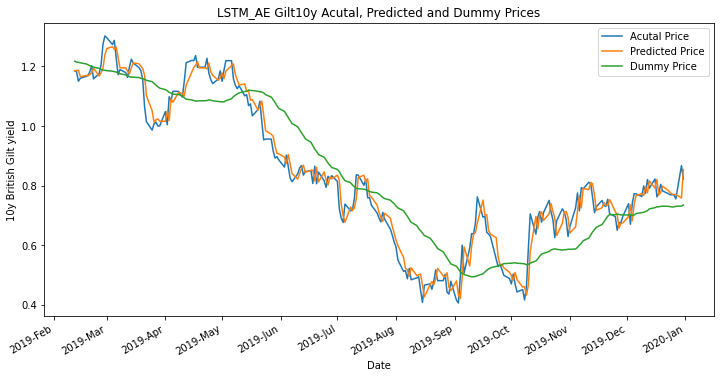

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

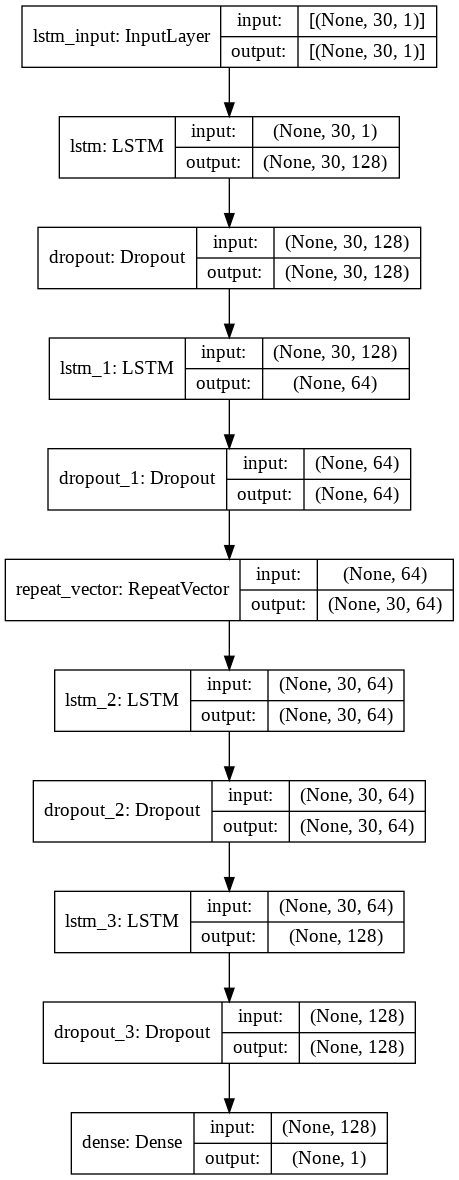

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.002562750960366023
RMSE:  0.050623620577414485
MAE:  0.04003875808134893
Dummy MSE:  0.013891737694778073
Dummy RMSE:  0.11786321603782103
Dummy MAE:  0.09977998323101281


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/LSTM_AE_Gilt10y/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/LSTM_AE_Gilt10y/assets
